<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
!pip3 install pymystem3

In [ ]:
!pip3 install catboost

In [ ]:
!pip3 install -U spacy

In [ ]:
!pip3 install wordcloud

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import re
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.probability import FreqDist

from tqdm import tqdm
from pymystem3 import Mystem
import warnings
warnings.filterwarnings('ignore')

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
try:
    data = pd.read_csv('C:/Users/pashc/Downloads/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [ ]:
data.info()

In [ ]:
data.head(10)

In [ ]:
data.sample(n=10)

In [ ]:
display(data['toxic'].value_counts())

In [ ]:
data.duplicated().sum()

Проведем лемитизацию и почистим данные от разделителей строк и заглавных символов

In [ ]:
def clearly_text(text):
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return " ".join(text.split())

In [ ]:
data['text'] = data['text'].apply(clearly_text)

In [ ]:
def lemm_text(text):
    doc = nlp(text)
    return  " ".join([token.lemma_ for token in doc])

In [ ]:
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemm_text)

In [ ]:
data = data.drop(['text'], axis=1)

In [ ]:
data

Частотный анализ текста

In [ ]:
text_tokens = word_tokenize(' '.join(data['lemm_text']))
stopwords = set(nltk_stopwords.words('english'))
filtered_text_tokens = [word for word in text_tokens if word not in stopwords]
text = nltk.Text(filtered_text_tokens)
fdist = FreqDist(text)

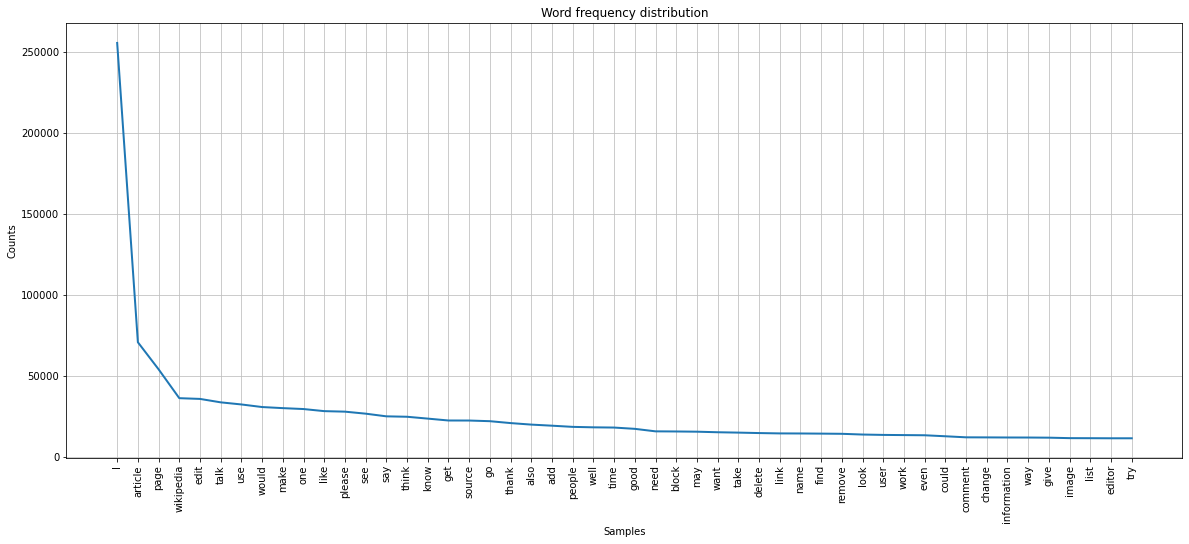

In [ ]:
plt.figure(figsize=(20, 8))
fdist.plot(50, cumulative=False, title='Word frequency distribution')
plt.show()

"Облако слов"

In [ ]:
text_raw = ' '.join(text)

In [ ]:
wordcloud = WordCloud().generate(text_raw)

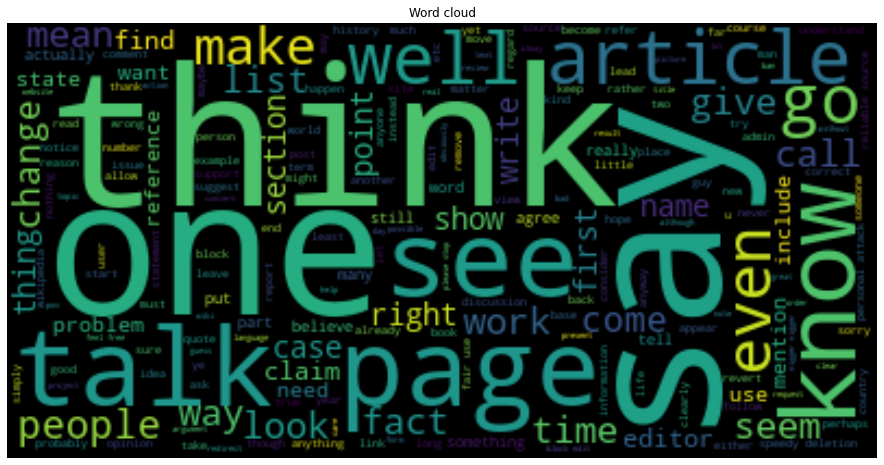

In [ ]:
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud')
plt.show()

Разделим на выборки и сделаем TFIDF

In [ ]:
target = data['toxic'].values
features = data['lemm_text']

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features,target,test_size=0.5,random_state=1515)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,target_valid,test_size=0.5,random_state=1515)

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [ ]:
tfidf_train = count_tf_idf.fit_transform(features_train)
tfidf_valid = count_tf_idf.transform(features_valid)
tfidf_test = count_tf_idf.transform(features_test)

**Вывод**: В результате работы были проанализированны данные и проведена лемитизация.Более того, мы сформировали выборки для обучения и провели векторизация TFIDF

## Обучение

In [ ]:
for depth in range(1,30):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1234)
    model.fit(tfidf_train,target_train)
    predictions = model.predict(tfidf_valid)
    f1 = f1_score(predictions, target_valid)
    print("Глубина дерева:", depth, f1)

In [ ]:
for c in range(1,6):
    for itery in range(1,300,100):
        model = model = LogisticRegression(random_state=12345, C = c, penalty = 'l1', solver='liblinear', max_iter=itery)
        model.fit(tfidf_train,target_train)
        predictions = model.predict(tfidf_valid)
        f1 = f1_score(predictions, target_valid)
        print("C:",c,"max_iter:",itery, f1)

In [ ]:
classificator = CatBoostClassifier(verbose=False, iterations=250)
classificator.fit(tfidf_train,target_train)
target_predict = classificator.predict(tfidf_valid)
f1 = f1_score(predictions, target_valid)
print('F1:', f1)

**Вывод**: Лучше всего результаты показала модель логической регрессии - 0.7767929089443996. На втором месте модель CatBoost с результатом 0.7750735490772933.

Тестрируем модель Логической регрессии

## Выводы

In [ ]:
model = LogisticRegression(random_state=12345, C = 4, penalty = 'l1', solver='liblinear', max_iter= 101)
model.fit(tfidf_train,target_train)
predictions  = model.predict(tfidf_test)
f1_score(target_test, predictions )

**Вывод**: Нам удалось достичь результата больше 0,75

## Итоговый вывод

Цель работы: создать модель для классифицировать комментариев на позитивные и негативные

- 1 этап : были проанализированы данные и леммитизация. Мы получили данные без пропусков и дубликатов и сформированы  сформированы обучающая, валидационная и тестовая выборки
- 2 этап : выбраны 3 модели - дерево решений, CatBoost, Логической регрессии. Была выбрана модель с лучшими резульатами
- 3 этап : тестирование модели логической регрессии и получение результата 0,77, что больше 0,75